In [1]:
import pandas as pd
train=pd.read_csv("C:/Users/sid/Desktop/Data_Science/Github_Codes/Kaggle_kernels/Project_2/train.csv")
test=pd.read_csv("C:/Users/sid/Desktop/Data_Science/Github_Codes/Kaggle_kernels/Project_2/test.csv")

In [2]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print("train shape is ",train.shape)
print("test shape is ",test.shape)

train shape is  (1460, 81)
test shape is  (1459, 80)


In [4]:
#Dropping ID
train_data=train.drop(['Id'],axis=1)
test_data=test.drop(['Id'],axis=1)

## Outllier Detection

Text(0.5,0,'GrLivArea')

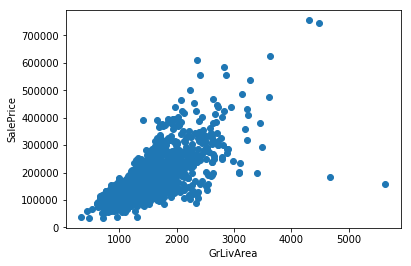

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax=plt.subplots()
ax.scatter(train_data['GrLivArea'],train_data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')

We can observe that there are 2 points with GrLivArea greater than 4000 but the SalePrice is much less.We consider them as outliers and remove them to make our model more robust .

In [6]:
#Removing outliers
train_data=train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)

Text(0.5,0,'GrLivArea')

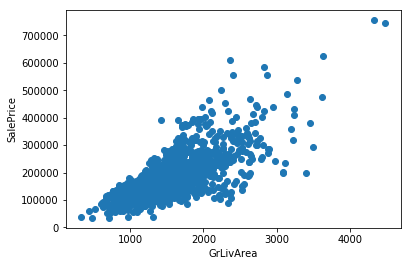

In [7]:
fig,ax=plt.subplots()
ax.scatter(train_data['GrLivArea'],train_data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')

### Checking for skewness in target variable

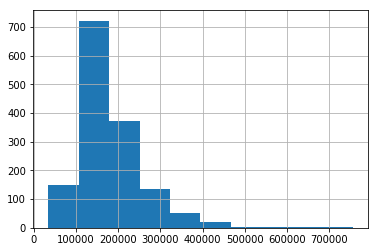

In [8]:
train_data['SalePrice'].hist()

mean=  180932.919067 and stdev=  79467.7889299


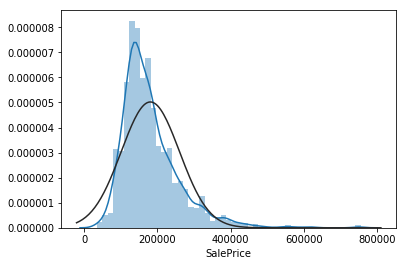

In [9]:
import seaborn as sns
from scipy.stats import norm
sns.distplot(train_data['SalePrice'],fit=norm)
mean,std=norm.fit(train_data['SalePrice'])
print("mean= ",mean, "and stdev= ",std)

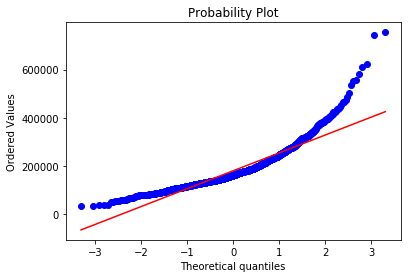

In [10]:
#qq plots
from scipy.stats import probplot
probplot(train['SalePrice'],plot=plt)
plt.show()

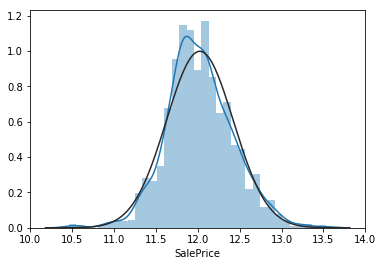

In [11]:
#Log transformation
import numpy as np
train_data['SalePrice']=np.log1p(train_data['SalePrice'])
sns.distplot(train_data['SalePrice'],fit=norm)

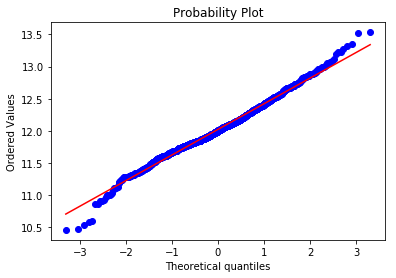

In [12]:
probplot(train_data['SalePrice'],plot=plt)
plt.show()

Log transformation worked on Sale price.The skew seems now corrected and the data appears more normally distributed

### Missing values

In [13]:
#Storing indixes for later
ntrain=train_data.shape[0]
ntest=test_data.shape[0]

In [14]:
ntrain

1458

In [15]:
#Concatanating data
y_train=train_data['SalePrice'].values
train_temp=train_data.drop(['SalePrice'],axis=1)
all_data=pd.concat([train_temp,test_data])
all_data.shape

(2917, 79)

In [16]:
missing_data=pd.DataFrame(round(all_data.isnull().sum()*100/all_data.shape[0],2),columns=['Missing_fraction']).reset_index()
temp=missing_data.sort_values(['Missing_fraction'],ascending=False).head(20)

Text(0.5,1,'Percent missing data by feature')

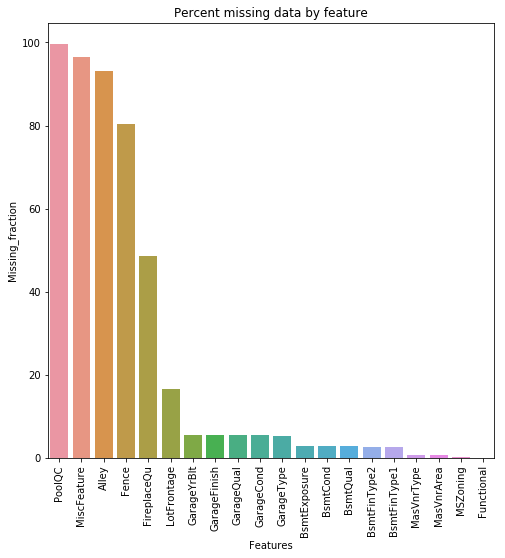

In [17]:
f,ax=plt.subplots(figsize=(8,8))
plt.xticks(rotation='90')
sns.barplot(x='index',y='Missing_fraction',data=temp)
plt.xlabel('Features')
plt.title('Percent missing data by feature')

### Correlation

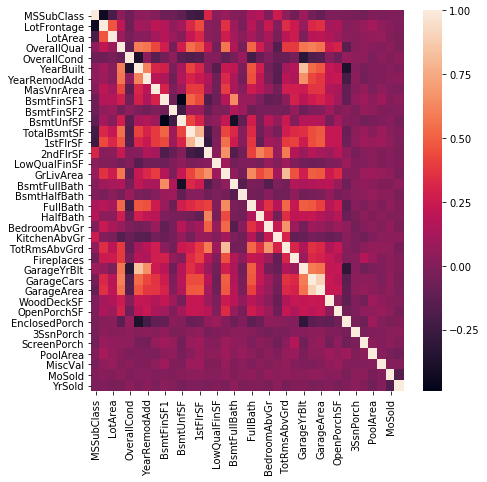

In [18]:
plt.subplots(figsize=(7,7))
sns.heatmap(all_data.corr())

### Imputing Missing values

In [19]:
#All features are filled according to their descriptions
#For example if the hose does not have a basement then it is filled as None,and the
#corresponding values of the basement such as Basement square footage are filled with 0.
#Similar approach to other features such as garage
columns_None=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
             'GarageType','GarageFinish','GarageQual','GarageCond',
             'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
             'BsmtFinType2','MasVnrType','MSSubClass']

columns_Zero=['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1',
             'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
             'MasVnrArea']

for i in columns_None:
    all_data[i]=all_data[i].fillna("None")

for j in columns_Zero:
    all_data[j]=all_data[j].fillna(0)

#### LotFrontage
LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [20]:
all_data['LotFrontage']=all_data.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x:x.fillna(x.median()))

#### MSZoning

In [21]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [22]:
all_data['MSZoning'].isnull().sum()

4

In [23]:
#Filling the missing values with mode
all_data['MSZoning']=all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

#### Utilities

In [24]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [25]:
#Only one value.Hence dropping utilities
all_data=all_data.drop(['Utilities'],axis=1)

#### Functional

In [26]:
#Functional : data description says NA means typical
all_data['Functional'].value_counts()

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [27]:
all_data['Functional'].isnull().sum()

2

In [28]:
all_data['Functional']=all_data['Functional'].fillna("Typ")

#### Electrical,KitchenQual,Exterior1st,Exterior2nd,SaleType

In [29]:
all_data['Electrical'].isnull().sum()

1

In [30]:
all_data['Electrical'].value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [31]:
#Filling with mode
all_data['Electrical']=all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [32]:
all_data['KitchenQual'].value_counts()

TA    1492
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [33]:
all_data['KitchenQual'].isnull().sum()

1

In [34]:
all_data['Exterior1st'].isnull().sum()

1

In [35]:
all_data['Exterior2nd'].isnull().sum()

1

In [36]:
all_data['SaleType'].isnull().sum()

1

Filling above features with mode since only one value is missing in each of them

In [37]:
for i in ['KitchenQual','Exterior1st','Exterior2nd','SaleType']:
    all_data[i]=all_data[i].fillna(all_data[i].mode()[0])

In [38]:
#checking if any missing values are remaining
all_data.isnull().sum().sum()

0

####  Transforming to corresponding numerical and categorical features

In [39]:
#Categorical Variables
for categ in ['MSSubClass','OverallCond','YrSold','MoSold']:
    all_data[categ]=all_data[categ].astype('str')

In [40]:
#Label Encoding
columns=('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

from sklearn.preprocessing import LabelEncoder

for i in columns:
    le=LabelEncoder()
    le.fit(list(all_data[i].values))    
    all_data[i]=le.transform(list(all_data[i].values))

In [41]:
all_data['MoSold'].value_counts()

8     503
9     446
7     394
6     279
10    233
5     232
1     172
11    158
2     142
4     133
0     121
3     104
Name: MoSold, dtype: int64

#Adding total square footage as one of the feature since it is absent 

In [42]:
all_data['Total_SF']=all_data['TotalBsmtSF']+all_data['1stFlrSF']+all_data['2ndFlrSF']

### Skewness

In [43]:
numeric_features=all_data.dtypes[all_data.dtypes!=object].index

In [44]:
from scipy.stats import skew
temp=pd.DataFrame(all_data[numeric_features].apply(lambda x :abs(x.skew())).sort_values(ascending=False),columns=['Skewness']).reset_index()
temp=temp.rename(columns={'index':'features'})
temp.head(10)

,features,Skewness
0,MiscVal,21.950962
1,PoolQC,21.228518
2,PoolArea,17.697766
3,Street,15.502729
4,LotArea,13.116240
5,LowQualFinSF,12.090757
6,3SsnPorch,11.377932
7,LandSlope,4.975813
8,KitchenAbvGr,4.302763
9,BsmtFinSF2,4.146636


Applying Box cox transormation on highly skewed features
http://onlinestatbook.com/2/transformations/box-cox.html


In [45]:
#(x^lambda-1/lambda)
skewed_features=temp[temp['Skewness']>0.75]['features'].values
from scipy.special import boxcox1p
for i in skewed_features:
    all_data[i]=boxcox1p(all_data[i],[0.15])

In [46]:
all_data[skewed_features].skew()

MiscVal           5.597842
PoolQC          -22.835591
PoolArea         15.767638
Street          -15.502729
LotArea           0.177826
LowQualFinSF      8.745528
3SsnPorch         8.926241
LandSlope         4.532595
KitchenAbvGr      3.699206
BsmtFinSF2        2.564554
Functional       -5.127355
EnclosedPorch     2.025363
ScreenPorch       2.978584
BsmtHalfBath      3.788634
GarageYrBlt      -3.925767
GarageCond       -4.176566
CentralAir       -3.459334
GarageQual       -3.442342
BsmtFinType2     -3.772005
PavedDrive       -3.065684
BsmtCond         -3.229921
MasVnrArea        0.637716
OpenPorchSF       0.099432
ExterCond        -3.015035
Fence            -2.538703
WoodDeckSF        0.224297
ExterQual        -2.855404
KitchenQual      -2.207198
1stFlrSF          0.179210
BsmtExposure     -1.408804
LotFrontage      -0.799316
GrLivArea         0.130118
Total_SF         -0.208110
BsmtFinSF1       -0.489117
BsmtUnfSF        -1.538077
2ndFlrSF          0.329048
dtype: float64

In [47]:
all_data=pd.get_dummies(all_data)
all_data.shape

(2917, 220)

In [48]:
train=all_data[:ntrain]
test=all_data[ntrain:]

## Building models

We cosider RMSE as the error metric for evaluation of our models

In [49]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline


We have used Bayesian Optimization frame work for Hyper parameter tuning .
https://github.com/fmfn/BayesianOptimization

#### Lasso

In [50]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score 
#train=all_data[:ntrain]
#test=all_data[ntrain:]

#Hyperparameter tuning for Lasso
rmse=[]
for i in [0.0001,0.001,0.01,0.1]:
    model_lasso=make_pipeline(RobustScaler(),Lasso(alpha=i,random_state=42))
    rmse.append(np.sqrt(-cross_val_score(model_lasso,train,y_train,cv=5,
                 scoring='neg_mean_squared_error')).mean())
print("rmse for lasso is ",min(rmse))    

rmse for lasso is  0.112215932995


#### Elastic net regression

In [51]:
from sklearn.linear_model import ElasticNet
rmse=[]
model_enet=make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=0.9,random_state=42))
rmse.append(np.sqrt(-cross_val_score(model_enet,train,y_train,cv=5,
                 scoring='neg_mean_squared_error')).mean())
print("rmse for enet is ",min(rmse)) 

rmse for enet is  0.110250755061


#### Kernel Ridge regression
Kernel Ridge regression is Ridge regression(l2 regularization) with the use of kernel trick.This is similar to Support Vector regression except for the loss function.In SVR the loss function use episolon insensitive loss where are KRR uses squared error loss both combined with l2 regularization

In [52]:
from sklearn.kernel_ridge import KernelRidge

rmse=[]
model_kridge=make_pipeline(RobustScaler(),KernelRidge(alpha=0.6,kernel='polynomial',degree=2,coef0=2.5))
rmse.append(np.sqrt(-cross_val_score(model_kridge,train,y_train,cv=5,
                 scoring='neg_mean_squared_error')).mean())
print("rmse for kridge is ",min(rmse)) 

rmse for kridge is  0.115927584999


#### Gradient Boosting

In [53]:
from sklearn.ensemble import GradientBoostingRegressor
#Using Huber loss to make it robust to outliers
model_gboost=GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
rmse=[]
rmse.append(np.sqrt(-cross_val_score(model_gboost,train.values,y_train,cv=5,
                 scoring='neg_mean_squared_error')).mean())
print("rmse for Gradient Boosting is ",min(rmse)) 

rmse for Gradient Boosting is  0.117222321117


#### xgboost

In [54]:
from xgboost import XGBRegressor
model_xgboost = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, nthread = -1)
rmse=[]
rmse.append(np.sqrt(-cross_val_score(model_xgboost,train,y_train,cv=5,
                 scoring='neg_mean_squared_error')).mean())
print("rmse for Xgboost is ",min(rmse)) 

C:\Users\sid\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


rmse for Xgboost is  0.115799510146


### Stacked models

In [55]:
from sklearn.base import clone
class averagedmodels():
    
    """ Instantiating the model with various base learners"""
    """ Give base learners as a list"""
    def __init__(self,models):
        self.models=models
    
    def fit(self,X,y):
        self.models_=[clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        predictions=np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions,axis=1)
          

In [56]:
#Instantiating class averaged models
averaged_models = averagedmodels(models = [model_enet,model_xgboost,
                                          model_gboost,model_kridge,model_lasso])
averaged_models.fit(train.values,y_train)


In [57]:
#axis=0 columns,axis=1 row
temp=np.sqrt(np.mean(pow((averaged_models.predict(train.values)-y_train),2)))
print("rmse from averaged models is ",temp)

rmse from averaged models is  0.0903275446964


 ### Stacked Regression

To build stacked regression ,divide the train data set into 2 parts A,B.
Steps:
1. Train algorithm on A and predict on B.This prediction will be B1.Use the model to predict on test.These predictions will be C1.
2.Similarly train different algorithms and the predictions will be the new columns in B1 and C1.
3.As we know the actual values oF B1,we train the model on B1 which is called a metal model and test on C1 to capture the predictions

In [58]:
from sklearn.model_selection import KFold
def Stackedregression(base_models,train,test,meta_learner,nfolds):
    """This function takes train and test data and returns two tables B and C on which we then 
    perform Stacked regression using a metalearner""" 
    kf=KFold(n_splits=nfolds,shuffle=False,random_state=42)
    """We define an empty array table and fill the appropriate values with the help of indices"""
    table_B=np.zeros((train.values.shape[0],len(base_models)))
    table_C=np.zeros((test.values.shape[0],len(base_models)))
    
    """Give base models as a list"""
    for index,model in enumerate(base_models):
        for train_index,holdout_index in kf.split(train):
            
            X_train,X_holdout=train.values[train_index],train.values[holdout_index]
            y_traindata,y_holdout=y_train[train_index],y_train[holdout_index]
            
            #building table B for train
            model_regr=clone(model)
            model_regr.fit(X_train,y_traindata)
            y_pred=model_regr.predict(X_holdout)
            table_B[holdout_index,index]=y_pred
        
        #Building table for C    
        y_predtest=model_regr.predict(test.values)
        table_C[test.index,index]=y_predtest
        
   
            
    table_B=pd.DataFrame(table_B,columns=[i for i in range(len(base_models))])
    table_C=pd.DataFrame(table_C,columns=[i for i in range(len(base_models))])
    table_B=pd.concat([table_B,pd.DataFrame(y_train,columns=['Target'])],axis=1)
    
    """Training the model on tabe B and predicting on table C using meta learner"""
    b_train,b_test=table_B.drop(['Target'],axis=1).values,table_B['Target'].values  
    meta_learner=clone(meta_learner)
    meta_learner.fit(b_train,b_test)
    
    
    """Predicting on table C"""
    
    y_testpredict=meta_learner.predict(table_C.values)
    

   
    return table_B,table_C,y_testpredict  
        
    

In [59]:
tab1,tab2,y3=Stackedregression(base_models=[model_lasso,model_enet,model_kridge,model_gboost],
                  train=train,test=test,nfolds=5,meta_learner=model_xgboost)

In [80]:
temp=pd.read_csv("C:/Users/sid/Desktop/Data_Science/Github_Codes/Kaggle_kernels/Project_2/test.csv")
submit=pd.DataFrame()
submit['Id']=temp['Id']
submit['SalePrice']=y3